In [2]:
DATA_DIR = r"C:/Users/deepe/Datasets/Kidney"


In [3]:
import os
print(os.listdir(DATA_DIR))


['Cyst', 'kidneyData.csv', 'Normal', 'Stone', 'Tumor']


In [4]:
from torchvision import datasets, transforms

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

full_ds = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
print(len(full_ds), full_ds.classes)


12446 ['Cyst', 'Normal', 'Stone', 'Tumor']


In [5]:
import os
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [6]:
# Config
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 16          # start safe; increase to 32 if GPU is fine
NUM_WORKERS = 0          # Windows/Jupyter: keep 0 to avoid hangs
PIN_MEMORY = torch.cuda.is_available()

TRAIN_FRAC = 0.70
VAL_FRAC = 0.15

HEAD_EPOCHS = 5
FT_EPOCHS = 10

LR_HEAD = 1e-3
LR_FT = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)


In [8]:
DATA_DIR = Path(r"C:/Users/deepe/Datasets/Kidney")  # <-- change if needed
print("Exists:", DATA_DIR.exists())
print("Contents:", os.listdir(DATA_DIR))


Exists: True
Contents: ['Cyst', 'kidneyData.csv', 'Normal', 'Stone', 'Tumor']


In [9]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [10]:
full_ds = datasets.ImageFolder(root=str(DATA_DIR), transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)

print("Total images:", len(full_ds))
print("Classes:", class_names)


Total images: 12446
Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [11]:
n_total = len(full_ds)
n_train = int(TRAIN_FRAC * n_total)
n_val   = int(VAL_FRAC * n_total)
n_test  = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

# IMPORTANT: no augmentations for val/test
val_ds.dataset.transform = eval_tfms
test_ds.dataset.transform = eval_tfms

print("Split sizes:", n_train, n_val, n_test)


Split sizes: 8712 1866 1868


In [12]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


In [13]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()


In [14]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, total = 0.0, 0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total += x.size(0)

    return total_loss / total


In [15]:
# Freeze all
for p in model.parameters():
    p.requires_grad = False

# Unfreeze classifier head
for p in model.classifier.parameters():
    p.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_HEAD)

best_val_acc = -1.0
best_state = None

for epoch in range(1, HEAD_EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_acc = evaluate(model, val_loader)
    print(f"[Head] Epoch {epoch}/{HEAD_EPOCHS} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_acc={va_acc:.4f}")

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

print("Best val_acc (head):", best_val_acc)


[Head] Epoch 1/5 | train_loss=0.6106 | val_loss=0.3045 | val_acc=0.9030
[Head] Epoch 2/5 | train_loss=0.3935 | val_loss=0.2071 | val_acc=0.9405
[Head] Epoch 3/5 | train_loss=0.3367 | val_loss=0.1692 | val_acc=0.9571
[Head] Epoch 4/5 | train_loss=0.3185 | val_loss=0.1396 | val_acc=0.9609
[Head] Epoch 5/5 | train_loss=0.2977 | val_loss=0.1226 | val_acc=0.9705
Best val_acc (head): 0.9705251875669882


In [16]:
model.load_state_dict(best_state)
model = model.to(DEVICE)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


              precision    recall  f1-score   support

        Cyst     0.9744    0.9798    0.9771       544
      Normal     0.9757    0.9871    0.9814       773
       Stone     0.9588    0.8942    0.9254       208
       Tumor     0.9565    0.9621    0.9593       343

    accuracy                         0.9700      1868
   macro avg     0.9663    0.9558    0.9608      1868
weighted avg     0.9699    0.9700    0.9698      1868

Confusion matrix:
 [[533   3   4   4]
 [  0 763   2   8]
 [  9  10 186   3]
 [  5   6   2 330]]


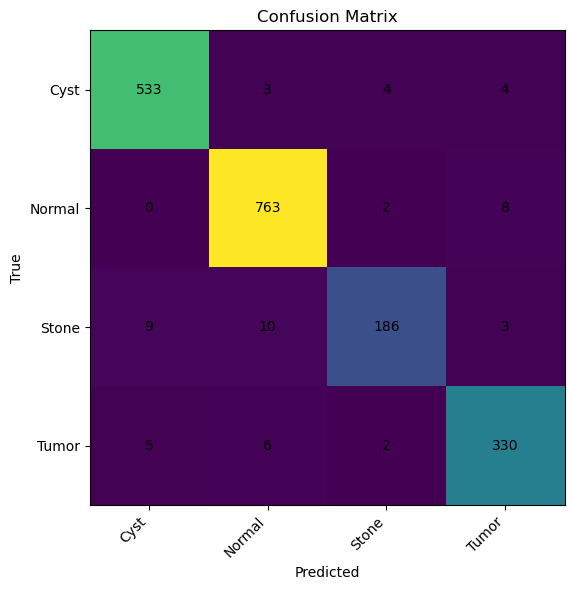

In [17]:
plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()
